In [1]:
import argparse
import sys
import os
import json
import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
BASE_DIR = "/Users/katemarg/PycharmProjects/temporal_robustness_evaluation"
DATA_DIR = os.path.join(BASE_DIR, 'data')
CKPT_DIR = os.path.join(BASE_DIR, 'pretrained_models')
RES_DIR = os.path.join(BASE_DIR, 'results')
LOG_DIR = os.path.join(BASE_DIR, 'logs')
CACHE_DIR = os.path.join(BASE_DIR, 'cached')

available_datasets = {
    "lama-conceptnet": {
        "data_dir" : os.path.join(DATA_DIR, "lama", "ConceptNet")
    },
    "lama-google-re": {
        "data_dir": os.path.join(DATA_DIR, "lama", "Google_RE")
    },
    "lama-squad": {
        "data_dir": os.path.join(DATA_DIR, "lama", "Squad")
    },
    "lama-trex": {
        "data_dir": os.path.join(DATA_DIR, "lama", "TREx")
    },
    "templama": {
        "data_dir": os.path.join(DATA_DIR, "templama")
    }
}

# Results with single-token only for TempLAMA 
- `TimeLMs`: Twitter-based RoBERTa models trained quarterly from Dec 2019 until Mar 2022
- `TempLAMA`: test set of 9 facts (templates) that change across time (yearly from 2010 to 2020)

In [3]:
results_df = pd.read_csv(os.path.join(RES_DIR, "timelms_templama_single_mask_new_new.csv"))
# results_df = pd.read_csv(os.path.join(RES_DIR, "timelms_templama_single_mask_results.csv"))
results_df['model'] = results_df['model'].apply(lambda x: x.split('-')[-1])
results_df.loc[results_df['model'] == "90m", 'model'] = "dec2019"

In [5]:
results_df = results_df
last_4_years_df = results_df[results_df['year']>=2018]

In [6]:
roberta_results_df = pd.read_csv(os.path.join(RES_DIR, "roberta-base_roberta-large_templama_single_mask_new_new.csv"))
roberta_results_df_4years = roberta_results_df[roberta_results_df['year']>=2018]

In [7]:
df_all = roberta_results_df.append(results_df, ignore_index=True)

/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_99939/1616948364.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = roberta_results_df.append(results_df, ignore_index=True)


In [8]:
df_5_years = df_all[df_all['year']>=2018]

In [9]:
P_at_20 = df_all[['model','year', 'P@20']]

In [10]:
P_at_20[P_at_20['year']==2022]['P@20']

12     0.5472
25     0.5276
38     0.3071
51     0.3346
64     0.3386
77     0.3228
90     0.3346
103    0.3622
116    0.3622
129    0.3622
142    0.3543
155    0.3425
Name: P@20, dtype: float64

In [11]:
P_at_20[P_at_20['model']=='roberta-base']['P@20'].tolist()

[0.6437,
 0.6559,
 0.6457,
 0.6055,
 0.6203,
 0.6131,
 0.5914,
 0.6048,
 0.5725,
 0.5769,
 0.5657,
 0.5543,
 0.5472]

In [12]:
[0.6437, 0.6559, 0.6457,0.6055, 0.6203, 0.6131, 0.5914, 0.6048, 0.5725, 0.5769, 0.5657, 0.5543,0.5472]

[0.6437,
 0.6559,
 0.6457,
 0.6055,
 0.6203,
 0.6131,
 0.5914,
 0.6048,
 0.5725,
 0.5769,
 0.5657,
 0.5543,
 0.5472]

### The task is Masked Language Modeling (MLM) / Fill-Mask and the evaluation metric is P@k.

In [13]:
def boxplot_vis(label, df):
    sns.barplot(x='year', y=label, data=df, hue='model', palette="rocket")
    sns.despine(offset=10, trim=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.title("TempLAMA / single token / {}".format(label))
    plt.savefig('plots/{}_per_year.png'.format(label), bbox_inches = 'tight',edgecolor='white')

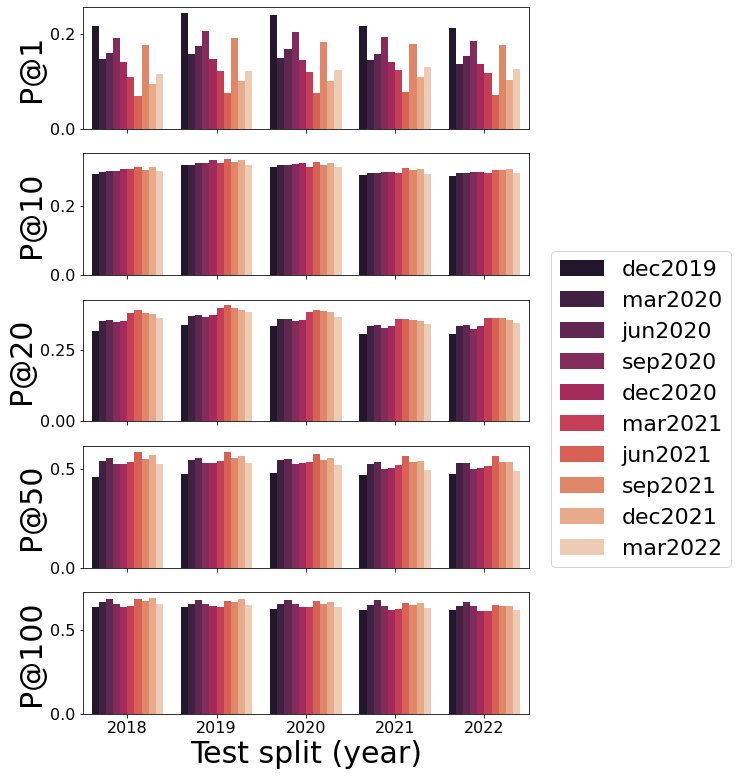

In [25]:
fig, axs = plt.subplots(5,1, figsize=(8, 13), sharex=True)
sns.barplot(x='year', y="P@1", data=last_4_years_df, hue='model', palette="rocket", ax=axs[0])
sns.barplot(x='year', y="P@10", data=last_4_years_df, hue='model', palette="rocket", ax=axs[1])
sns.barplot(x='year', y="P@20", data=last_4_years_df, hue='model', palette="rocket", ax=axs[2])
sns.barplot(x='year', y="P@50", data=last_4_years_df, hue='model', palette="rocket", ax=axs[3])
sns.barplot(x='year', y="P@100", data=last_4_years_df, hue='model', palette="rocket", ax=axs[4])
[ax.get_legend().remove() for ax in axs[:-1]]
[ax.set_xlabel("") for ax in axs[:-1]]
axs[4].set_xlabel("Test split (year)")
plt.legend(bbox_to_anchor=(1.05,3.8), loc='upper left', borderaxespad=0, prop={'size': 22})
for ax in axs:
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)
plt.rcParams.update({'font.size': 30})
plt.savefig('plots/P@k_last_5_years_all_models.png', bbox_inches = 'tight',edgecolor='white',dpi=500)

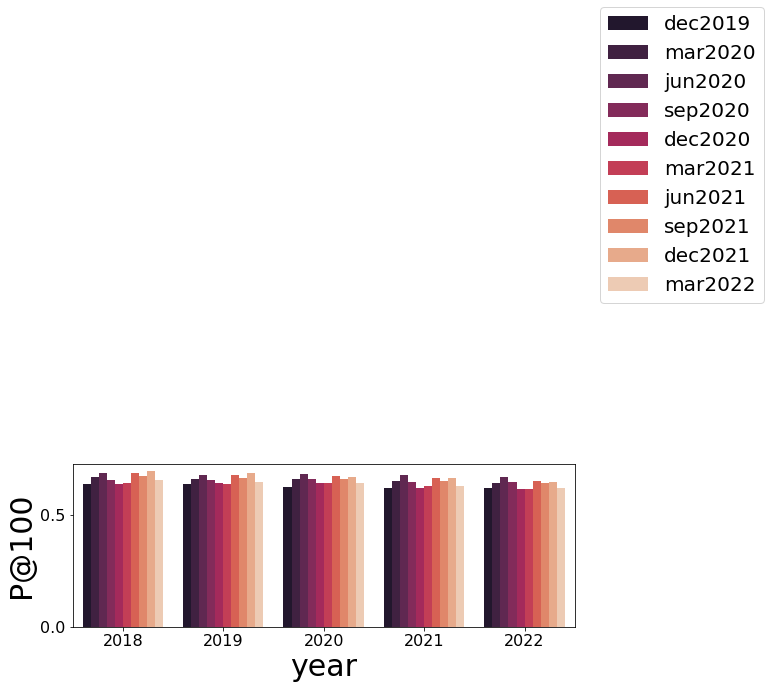

In [30]:
fig, ax = plt.subplots(1,1, figsize=(9, 3), sharex=True)
sns.barplot(x='year', y="P@100", data=last_4_years_df, hue='model', palette="rocket", ax=ax)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
plt.rcParams.update({'font.size': 30})
plt.legend(bbox_to_anchor=(1.05,3.8), loc='upper left', borderaxespad=0, prop={'size': 20})
plt.savefig('plots/P@100_last_5_years_all_models.png', bbox_inches = 'tight',edgecolor='white',dpi=500)

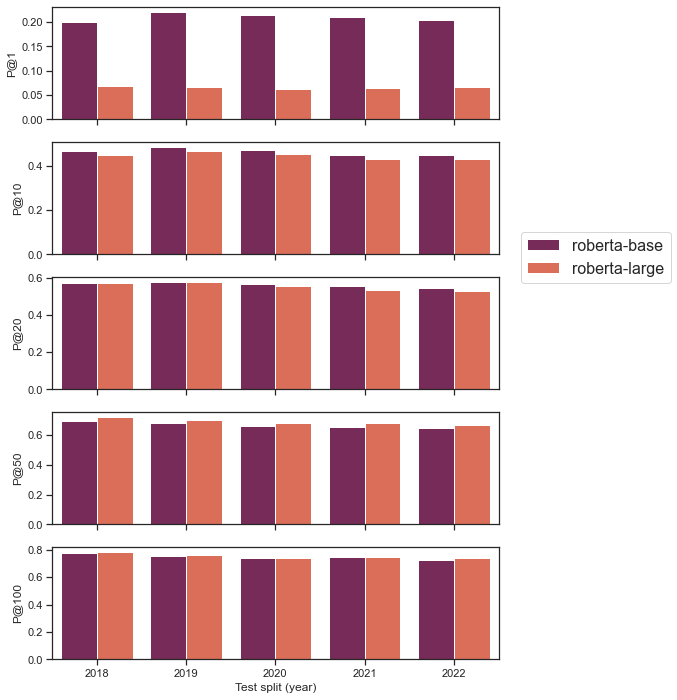

In [76]:
fig, axs = plt.subplots(5,1, figsize=(8, 12), sharex=True)
sns.barplot(x='year', y="P@1", data=roberta_results_df_4years, hue='model', palette="rocket", ax=axs[0])
sns.barplot(x='year', y="P@10", data=roberta_results_df_4years, hue='model', palette="rocket", ax=axs[1])
sns.barplot(x='year', y="P@20", data=roberta_results_df_4years, hue='model', palette="rocket", ax=axs[2])
sns.barplot(x='year', y="P@50", data=roberta_results_df_4years, hue='model', palette="rocket", ax=axs[3])
sns.barplot(x='year', y="P@100", data=roberta_results_df_4years, hue='model', palette="rocket", ax=axs[4])
[ax.get_legend().remove() for ax in axs[:-1]]
[ax.set_xlabel("") for ax in axs[:-1]]
axs[4].set_xlabel("Test split (year)")
plt.legend(bbox_to_anchor=(1.05,3.8), loc='upper left', borderaxespad=0, prop={'size': 16})
plt.savefig('plots/P@k_last_4_years.png', bbox_inches = 'tight',edgecolor='white')

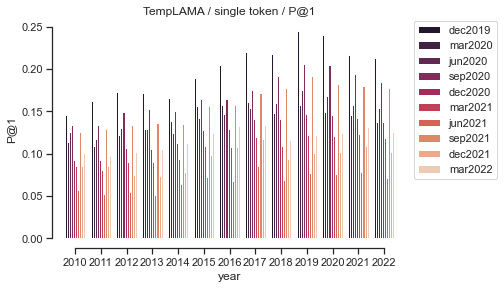

In [36]:
boxplot_vis("P@1", results_df)

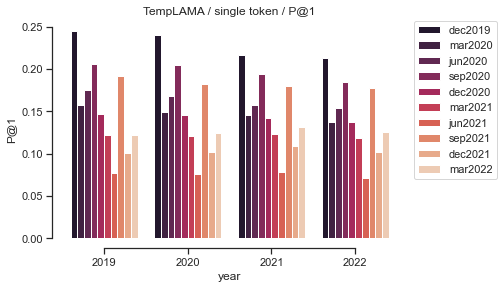

In [37]:
boxplot_vis("P@1", last_4_years_df)

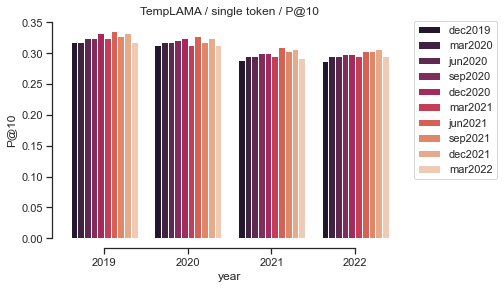

In [38]:
boxplot_vis("P@10", last_4_years_df)

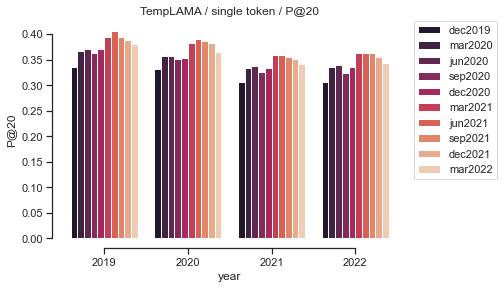

In [39]:
boxplot_vis("P@20", last_4_years_df)

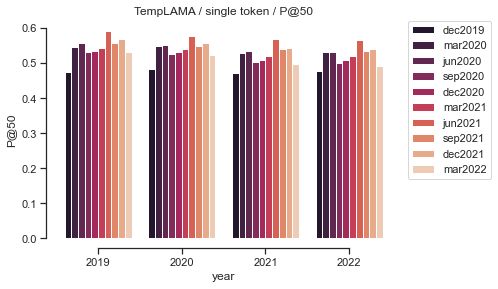

In [40]:
boxplot_vis("P@50", last_4_years_df)

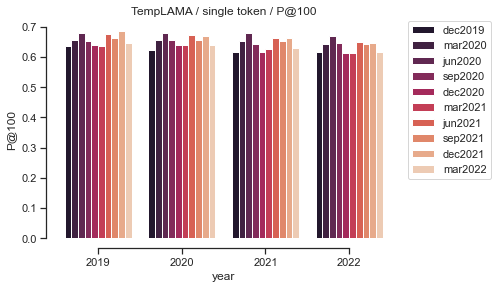

In [41]:
boxplot_vis("P@100", last_4_years_df)

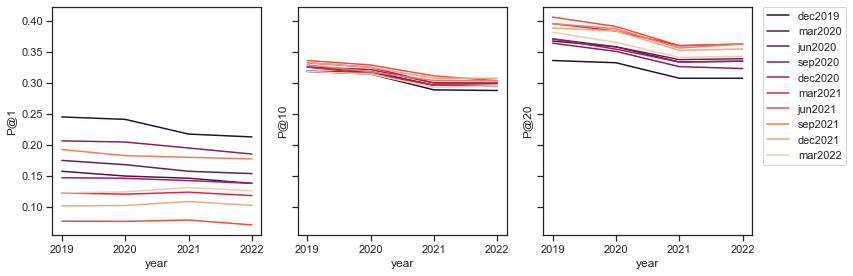

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12, 4), sharey=True)
sns.lineplot(
    data=last_4_years_df,
    x="year", 
    y="P@1",
    hue="model", 
    palette="rocket",
    ax=ax1,
    legend=False
)
ax2.set_ylabel("P@10")
sns.lineplot(
    data=last_4_years_df,
    x="year", 
    y="P@10",
    hue="model", 
    palette="rocket",
    ax=ax2,
    legend=False
)
ax3.set_ylabel("P@20")
sns.lineplot(
    data=last_4_years_df,
    x="year", 
    y="P@20",
    hue="model", 
    palette="rocket",
    ax=ax3
)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
fig.tight_layout()
plt.savefig('plots/p_over_time_lineplot.png', bbox_inches = 'tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


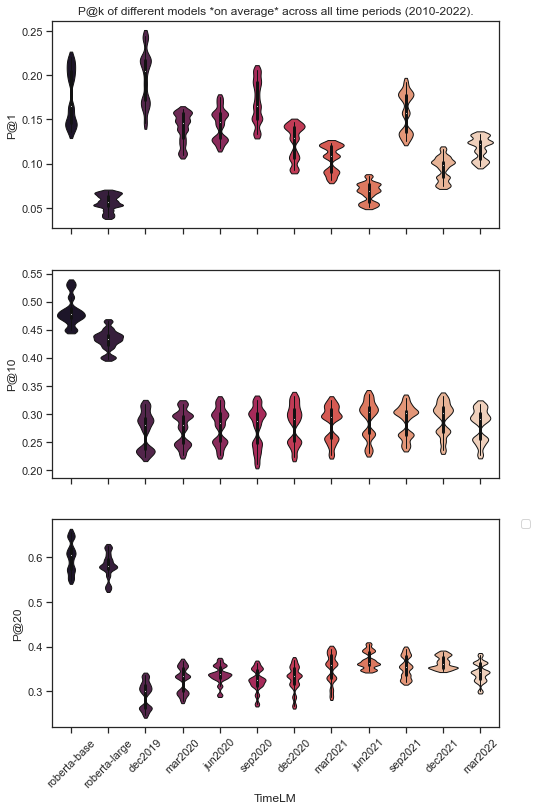

In [94]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8, 13), sharex=True)
# sns.set_theme(style="ticks")
sns.violinplot(data=df_all, y='P@1', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax1)
sns.violinplot(data=df_all, y='P@10', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax2)
sns.violinplot(data=df_all, y='P@20', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax3)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("TimeLM")
ax1.set_title('P@k of different models *on average* across all time periods (2010-2022).')
plt.savefig('plots/P@k_avg_time_allperiods.png', bbox_inches = 'tight', dpi=500)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


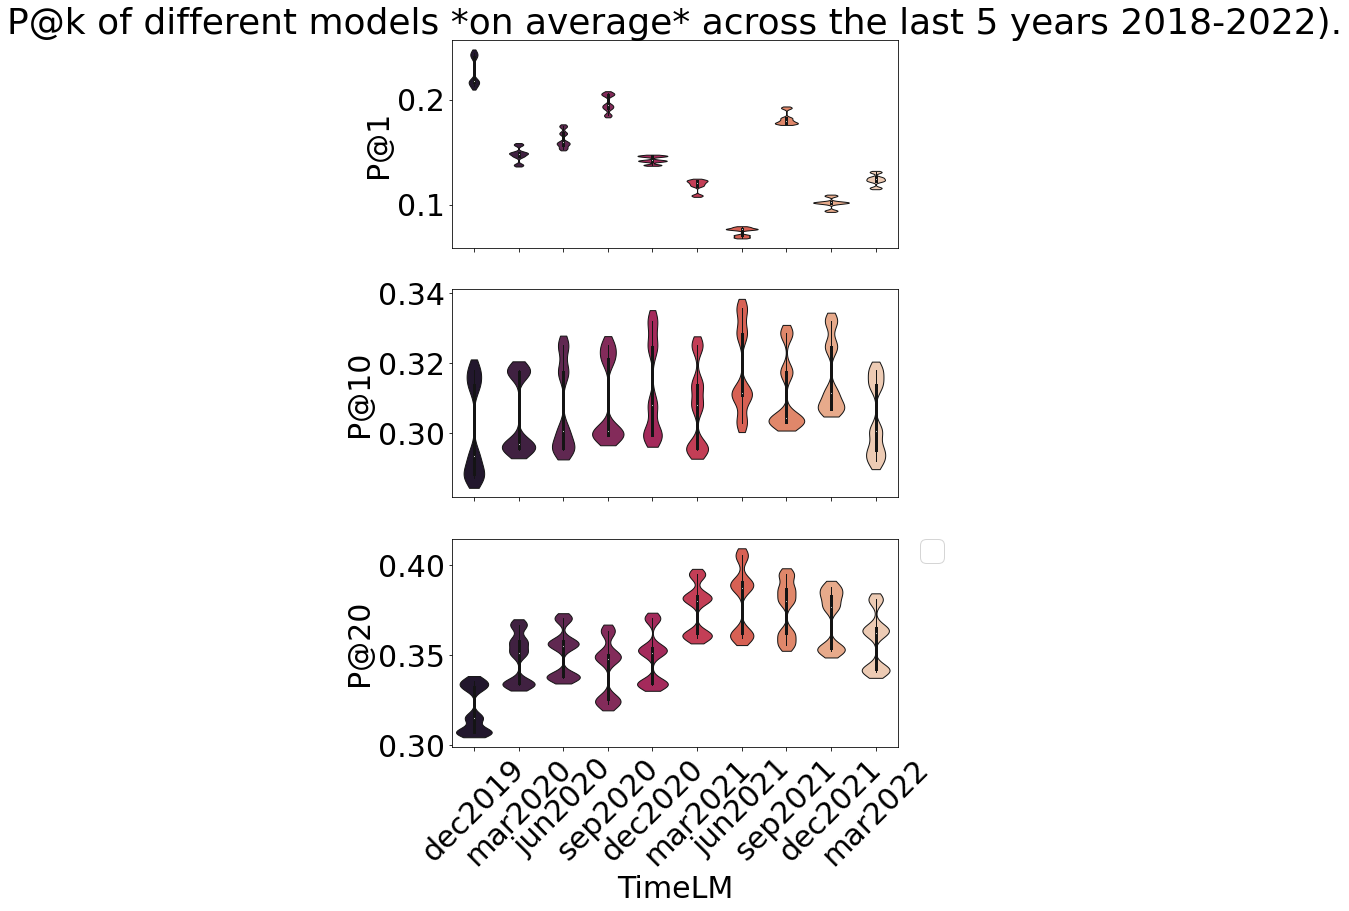

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8, 13), sharex=True)
# sns.set_theme(style="ticks")
sns.violinplot(data=last_4_years_df, y='P@1', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax1)
sns.violinplot(data=last_4_years_df, y='P@10', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax2)
sns.violinplot(data=last_4_years_df, y='P@20', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax3)
plt.xticks(rotation=45)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("TimeLM")
ax1.set_title('P@k of different models *on average* across the last 5 years 2018-2022).')
plt.savefig('plots/P@k_avg_time_last5years.png', bbox_inches = 'tight', dpi=500)

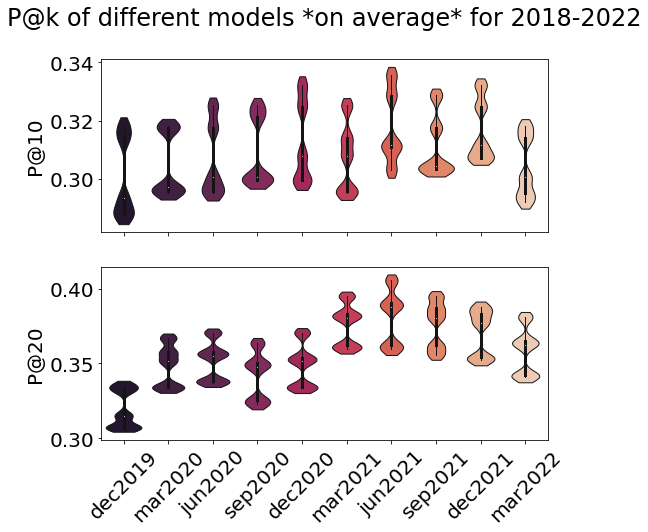

In [59]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 7), sharex=True)
# sns.set_theme(style="ticks")
# sns.violinplot(data=last_4_years_df, y='P@1', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax1)
sns.violinplot(data=last_4_years_df, y='P@10', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax1)
sns.violinplot(data=last_4_years_df, y='P@20', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax2)
plt.xticks(rotation=45)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# ax1.set_xlabel("")
# ax2.set_xlabel("")
# ax3.set_xlabel("TimeLM")
# ax1.set_title('P@k of different models *on average* for 2018-2022).')
# ax1.set_title('')
for ax in axs:
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)
plt.rcParams.update({'font.size': 20})
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("TimeLM")
ax1.set_title('P@k of different models *on average* for 2018-2022\n')
# fig.tight_layout()
plt.savefig('plots/P@k_avg_time_last5years.png', bbox_inches = 'tight', dpi=500)